In [1]:
import os
import torch
import torchaudio
import sys
notebook_dir = os.getcwd()
sys.path.append(os.path.join(notebook_dir, "../src_torch_extend"))
from IPython.display import Audio
import pickle
import soundfile as sf
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

from separation.FastMNMF2 import FastMNMF2
from Base import MultiSTFT, MultiISTFT

number_of_notes = [36, 15, 15]
audio_src_dir = "Shubert_v2"
dict_dir = "dict"

dict_path = os.path.join(notebook_dir, "../", dict_dir)


## Extract dictionary, using NMF

#### From recorded solo

In [2]:
# TODO: NMF and its reconstruction doesn't have a good performance

audio_src_names = np.array(["piano_brut.wav", "clarinette_brut.wav", "violon_brut.wav"])
audio_paths = [os.path.join(notebook_dir, "../", audio_src_dir, audio_src_name) for audio_src_name in audio_src_names]

n_fft = 2048
hop_length = 512
W = []
H = []
max_T = 0
for idx in range(len(audio_paths)):
    audio_path = audio_paths[idx]
    y, sr = librosa.load(audio_path, sr=44100)
    y /= np.abs(y).max() * 1.2
    D = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    model = NMF(n_components=number_of_notes[idx], init='nndsvda', solver='mu', beta_loss='kullback-leibler', random_state=42, max_iter=2000)
    W_k = model.fit_transform(D) # [F, K]
    H_k = model.components_ # [K, T]
    print(f'reconstruction error: {model.reconstruction_err_}, stop iter: {model.n_iter_} at {audio_src_names[idx]}')
    max_T = max(max_T, H_k.shape[1])
    # zero padding for W_k, to make it the same size for all K, [F, max(K)]
    W_k = np.pad(W_k, ((0, 0), (0, max(number_of_notes)-number_of_notes[idx])))
    W.append(W_k)
    H.append(H_k)

# zero padding for H_k, to make it the same size for all T, [K, max(T)]
H = [np.pad(H_k, ((0, max(number_of_notes)-H_k.shape[0]), (0, max_T-H_k.shape[1]))) for H_k in H]

W = np.array(W) # [N, F, K]
H = np.array(H) # [N, K, T]

with open(os.path.join(dict_path, "W.pkl"), "wb") as f:
    pickle.dump(W, f)
with open(os.path.join(dict_path, "H.pkl"), "wb") as f:
    pickle.dump(H, f)


reconstruction error: 236.40220791322994, stop iter: 210 at piano_brut.wav
reconstruction error: 907.1853104520598, stop iter: 80 at clarinette_brut.wav
reconstruction error: 537.5732508226205, stop iter: 170 at violon_brut.wav


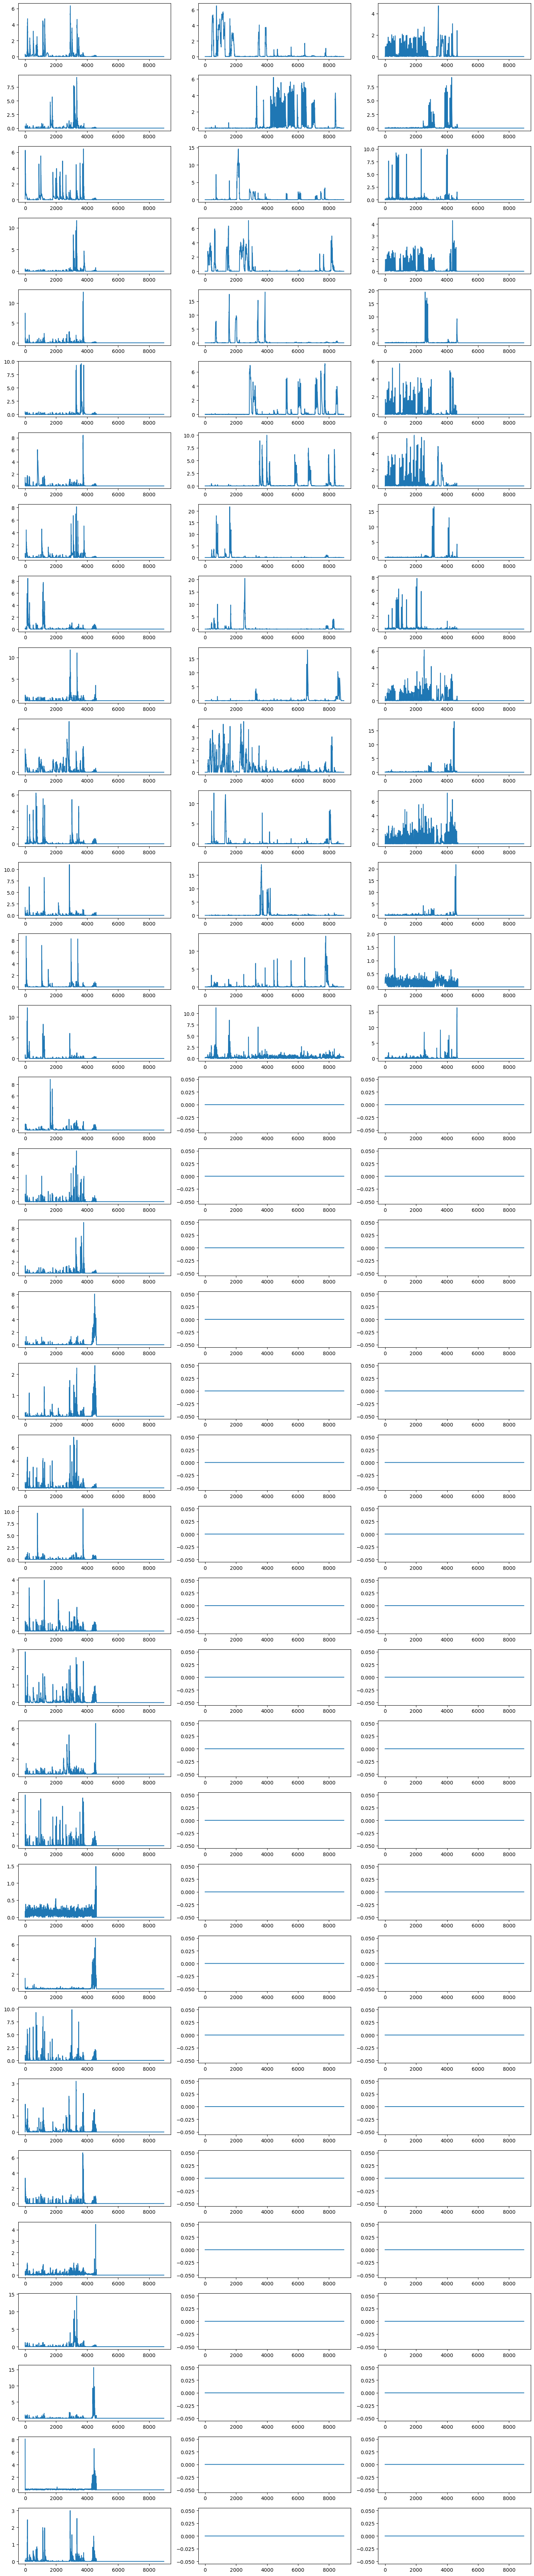

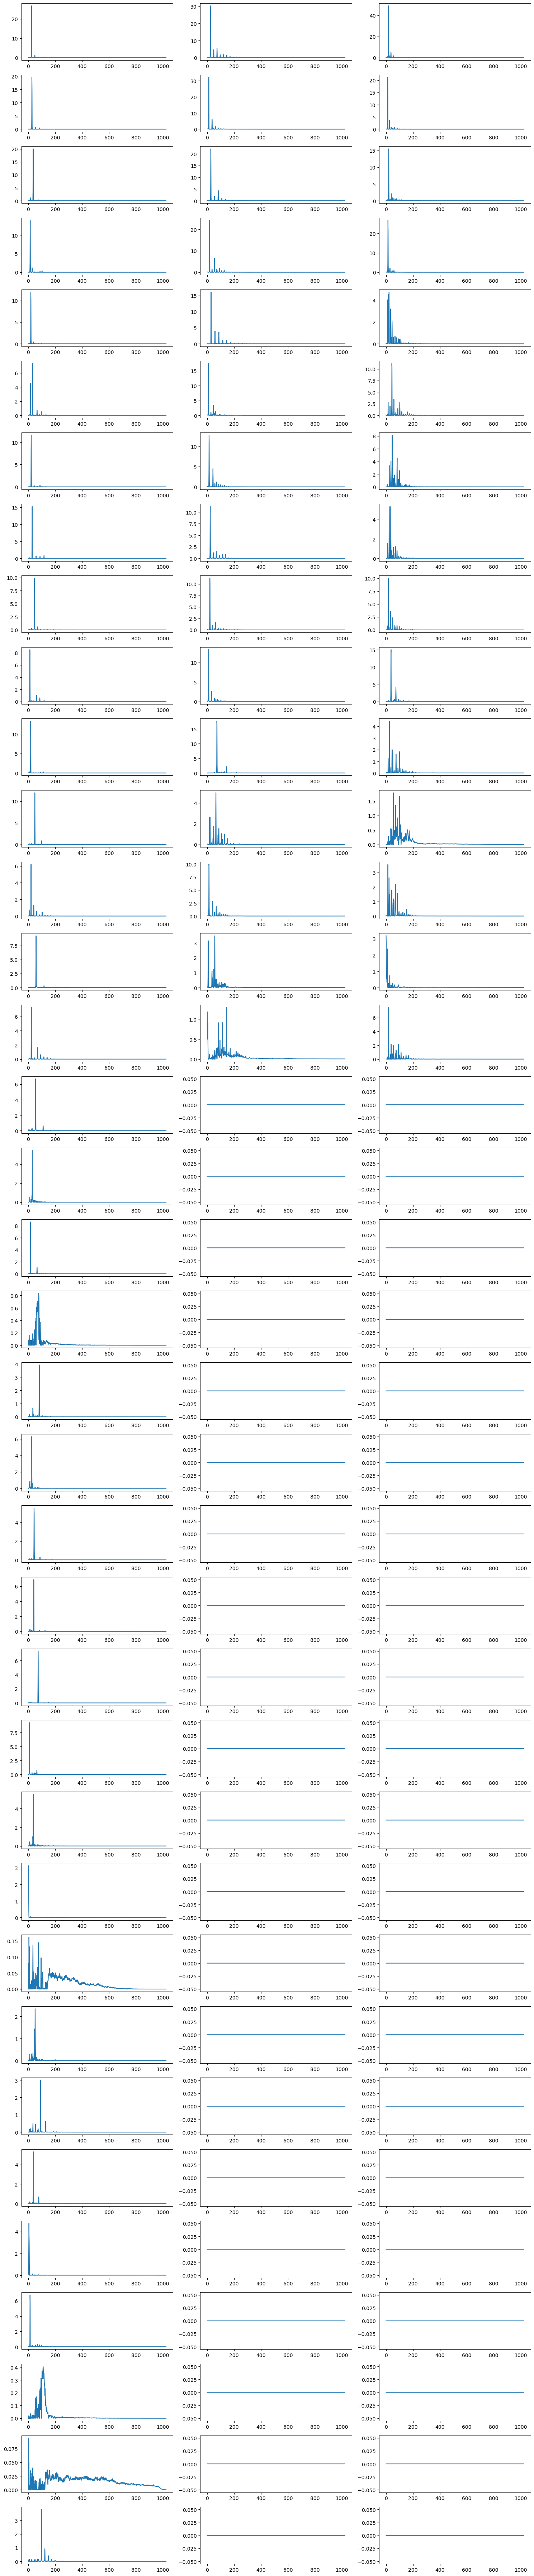

In [3]:
try :
    W, H
except NameError:
    print("Load W, H from pickle file")
    with open(os.path.join(dict_path, "W.pkl"), "rb") as f:
        W = pickle.load(f)
    with open(os.path.join(dict_path, "H.pkl"), "rb") as f:
        H = pickle.load(f)

K = max(number_of_notes)
fig, axs = plt.subplots(K, 3, figsize=(15, K*2))
for idx in range(K):
    for i in range(3):
        axs[idx, i].plot(H[i, idx, :])
    plt.tight_layout()
plt.show()

fig, axs = plt.subplots(K, 3, figsize=(15, K*2))
for idx in range(K):
    for i in range(3):
        axs[idx, i].plot(W[i, :, idx])
    plt.tight_layout()
plt.show()

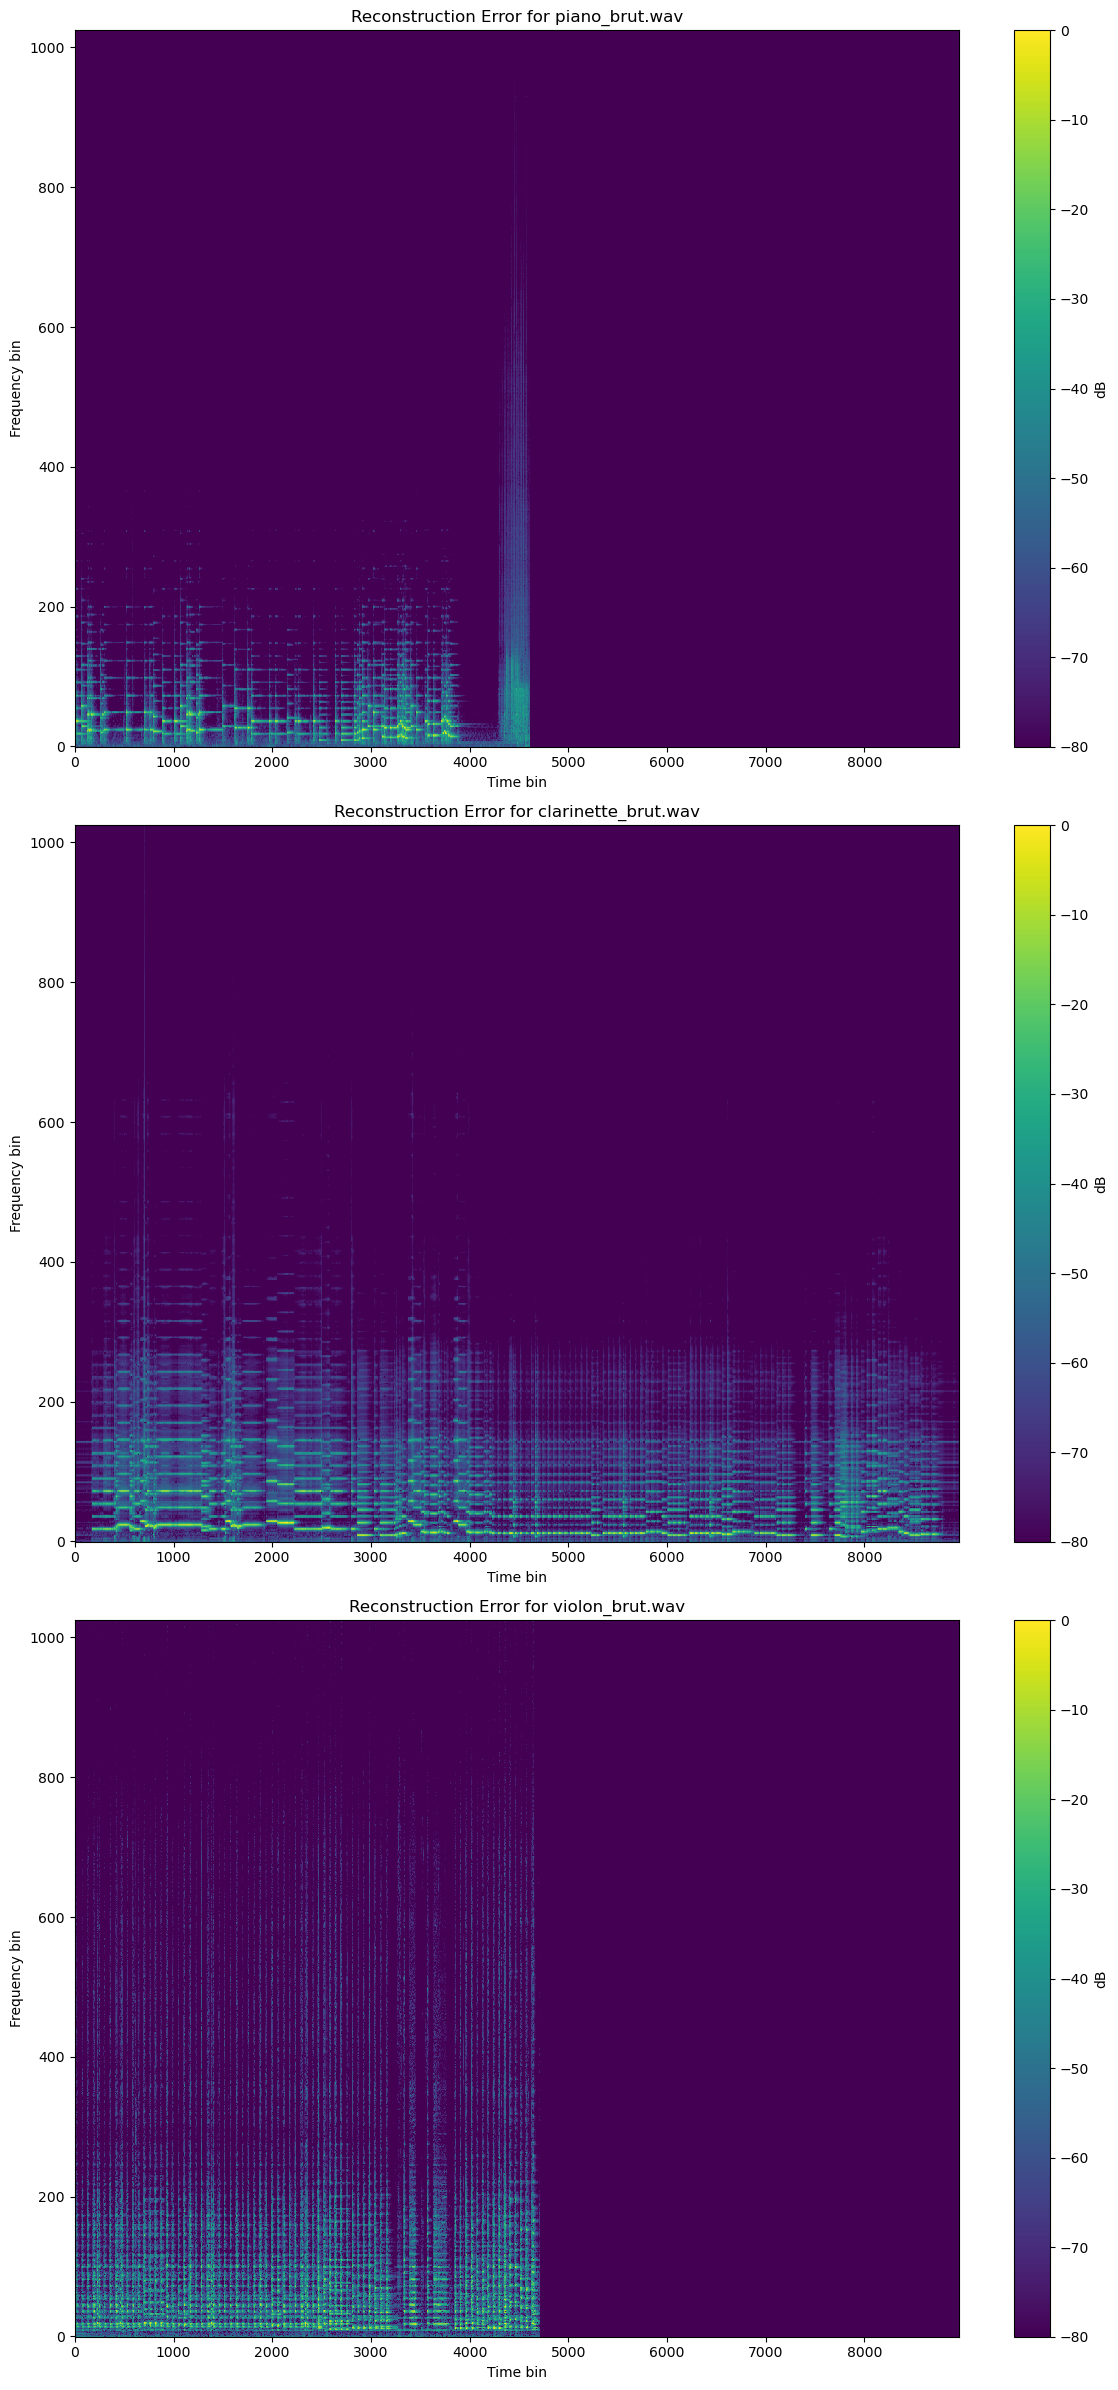

In [4]:
try :
    W, H
except NameError:
    print("Load W, H from pickle file")
    with open(os.path.join(dict_path, "W.pkl"), "rb") as f:
        W = pickle.load(f)
    with open(os.path.join(dict_path, "H.pkl"), "rb") as f:
        H = pickle.load(f)
        
fig, axs = plt.subplots(len(audio_paths), 1, figsize=(12, 8*3))
for idx in range(len(audio_paths)):
    V = W[idx,:,:] @ H[idx,:,:]
    audio_path = audio_paths[idx]
    y, sr = librosa.load(audio_path, sr=44100)
    D = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    # zero padding for D to make it the same size for all T, [F, max(T)]
    D = np.pad(D, ((0, 0), (0, max_T-D.shape[1])))

    # plot the reconstruction error
    axs[idx].imshow(librosa.amplitude_to_db(D-V, ref=np.max), aspect='auto', origin='lower', interpolation='none')
    axs[idx].set_title(f'Reconstruction Error for {audio_src_names[idx]}')
    fig.colorbar(axs[idx].images[0], ax=axs[idx])
    axs[idx].set_xlabel('Time bin')
    axs[idx].set_ylabel('Frequency bin')
    axs[idx].images[0].colorbar.set_label('dB')
    
    # y_rec = librosa.istft(V, hop_length=hop_length)
    # Audio(y_rec, rate=sr)
    
plt.tight_layout()
plt.show()

# y_rec = librosa.istft(V, hop_length=hop_length)
# # sf.write('note_solo.wav', y_note_solo, sr)
# Audio(y_rec, rate=sr)

In [27]:
for idx in range(len(audio_paths)):
    V = W[idx,:,:] @ H[idx,:,:]
    y_rec = librosa.istft(V, hop_length=hop_length)
    sf.write(f'rec_{audio_src_names[idx]}', y_rec, sr)

## FastMNMF2

In [5]:
# load W if not exist
try:
    W, H
except NameError:
    print("Load W H from pickle file")
    with open(os.path.join(dict_path, "W.pkl"), "rb") as f:
        W = pickle.load(f)
    with open(os.path.join(dict_path, "H.pkl"), "rb") as f:
        H = pickle.load(f)

audio_src_name = "toutes_pistes_indiv_v2 ortf.wav"
audio_src_path = os.path.join(notebook_dir, "../", audio_src_dir, audio_src_name)

audio_save_dir = os.path.join(notebook_dir, "..", "result")
if not os.path.exists(audio_save_dir):
    os.makedirs(audio_save_dir)

n_source = 3
n_basis = np.max(number_of_notes) # = max(number_of_notes)
device = "cuda:1" if torch.cuda.is_available() else "cpu"
init_SCM = "circular"
n_bit = 32
algo = "IP"
n_iter_init = 20
g_eps = 5e-5

n_mic = 8
n_fft = 2048
n_iter = 200

# load audio
wav, sample_rate = torchaudio.load(audio_src_path, channels_first=False)
wav /= torch.abs(wav).max() * 1.2
M = min(len(wav), n_mic)
spec_FTM = MultiSTFT(wav[:, :M], n_fft=n_fft)

separater = FastMNMF2(
    n_source=n_source,
    n_basis=n_basis,
    device=device,
    init_WH='W',
    matrix_init=W,
    init_SCM=init_SCM,
    n_bit=n_bit,
    algo=algo,
    n_iter_init=n_iter_init,
    g_eps=g_eps,
)

separater.file_id = audio_src_path.split("/")[-1].split(".")[0]
separater.load_spectrogram(spec_FTM, sample_rate)
separater.solve(
    n_iter=n_iter,
    save_dir=audio_save_dir,
    save_likelihood=False,
    save_param=False,
    save_wav=True,
    interval_save=10,
)
torch.cuda.empty_cache()

Update FastMNMF2_IP-20250209-160412-M=8-S=3-F=1025-K=36-dict=W-init=circular-g=5e-05-bit=32-intv_norm=10-ID=toutes_pistes_indiv_v2 ortf  200 times ...


100%|██████████| 200/200 [03:52<00:00,  1.16s/it]
